## 文本纠错

---

### 介绍

在应用 word 等文档工具进行工作时，我们常常会到一个非常实用的功能，文本纠错，一般这些文档工具中的类似功能都能够将错误单词进行识别，甚至推荐纠正项。那么，这一功能是如何实现的呢？今天的实验就为大家介绍文本纠错的原理，以及通过两大案例，手把手地教大家实现两个英文及中文的纠错器。

#### 知识点

- 文本纠错概述
- 英文纠错实例
- 中文纠错实例

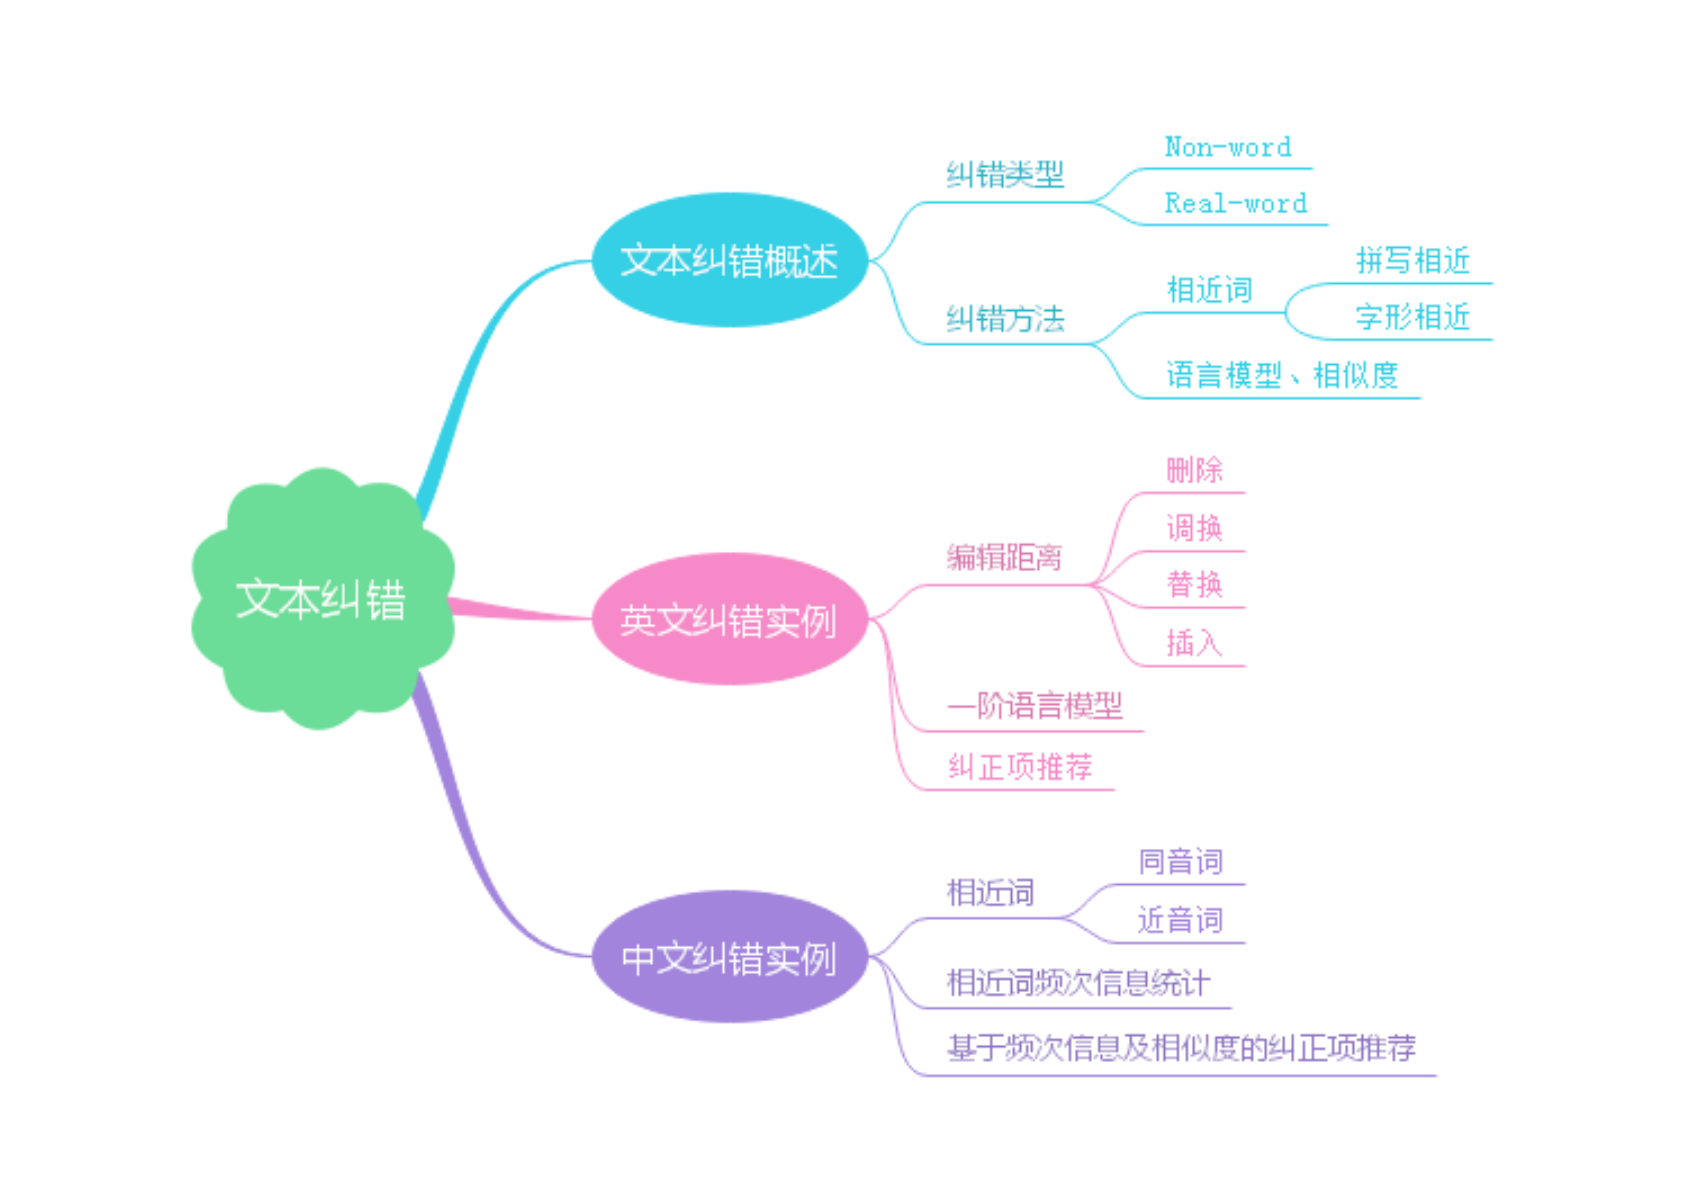

### 文本纠错概述

文本纠错又称为拼写检查，由于纯文本往往来源于手打或者 OCR（Optical Character Recognition,光学字符识别），很可能存在一些错误，因此此技术也是一大关键的文本预处理过程，一般可划分为两大错误类型：Non-word 拼写错误以及 Real-word 拼写错误。本实验重点介绍前者。

Non-word 拼写错误，表示此词汇本身在字典中不存在，比如把“因材施教”误写为“因才施教”，把 “correction” 误拼写为 “corrction”。这类问题的解决思路可分为两大步骤：

- 找到字典中与错拼词汇相近的词作为候选纠正词：例如对于错误单词 “atress”，存在多个相近候选词，比如 “actress”，“caress”，“stress”，“across”,“cress” 等。那么如何确定候选项呢？对于英文而言，通过编辑距离运算便可得到一系列相近候选词汇。而对于中文来说，一般存在两种相近模式，一是拼写相近，比如在拼音打字时出错，二则是字形相近，比如在五笔打字时出错，一般需要通过构建相近字词表查找候选词汇。
- 通过算法从候选项中选出最有可能的纠正选项：比如在当前例子中计算得 “actress” 为最佳纠正选项。一般情况下，有两大主要因素决定了某一候选项的可能性：“此选项在当前语境中出现的可能性”和“候选项和错误单词的相似度”，可结合两者进行综合判断。

这里值得注意的是，“选项在当前语境中出现的可能性”，其实便是“语言模型”的概念。如果是一元语言模型，只需统计单词在语料中的出现频次即可；如果是二阶或三阶语言模型，则需要统计单词在前一个或前两个单词出现的情况下出现的概率，比如计算“错误单词左边单词+候选项+错误单词右边单词”在语料中的出现情况，可以更好地综合上下文信息，来判断候选项在当前语境中出现的可能性。

Real-word 拼写错误，意思是指单词本身没有错误，但是不符合上下文语境，常常涉及语法语义层面的错误，比如把“我现在在公司里”错写成“我现在在公式里”，这类错误计算量较大，因为每个单词都是待纠错对象。通常的解决方案与第一种情况类似：

- 针对每个单词根据编辑距离、同音词、近形词等方式选出候选项（也包括待纠正单词本身）。
- 计算选项本身在当前语境中出现的可能性，以及候选项和原待纠正单词的相似度。
- 综合计算各候选项（也包括待纠正单词本身）是正确项的可能性，如果单词本身的概率较大，则不进行纠正，否则推荐纠正项。

注意：编辑距离（Minimum Edit Distance，MED），由俄罗斯科学家 Vladimir Levenshtein 在 1965 年提出，也因此而得名 Levenshtein Distance。通俗地来讲，编辑距离指的是在两个单词 <w1,w2> 之间，由其中一个单词 w1 转换为另一个单词 w2 所需要的最少单字符编辑操作次数。在这里定义的单字符编辑操作有且仅有三种：

- 插入（Insertion）
- 删除（Deletion）
- 替换（Substitution）

譬如，"kitten" 和 "sitting" 这两个单词，由 "kitten" 转换为 "sitting" 需要的最少单字符编辑操作有：

- kitten → sitten ("k" 替换为 "s" )
- sitten → sittin ("e" 替换为 "i" )
- sittin → sitting (末尾添加 "g")

因此，"kitten" 和 "sitting" 这两个单词之间的编辑距离为 3 。

### 英文纠错实例

现有一些英文语料，存放在文件 `english_data.txt` 中，如何基于此语料构建一个简单的英文 Non-word 拼写纠错工具呢？根据上文中的理论我们可以这样设计：

- 根据编辑距离计算某个错误单词的相似单词。
- 由于语料库比较小（如果统计二阶或三阶语言模型，稀疏程度会很高），这里只考虑一阶语言模型，即根据语料统计每个单词的出现频次，作为选项本身在当前语境中出现的可能性。
- 综合以上信息推荐候选纠正项。

首先，我们构建一个函数，对某一单词进行一些编辑改动，得到新的候选单词，方法如下：  

- 删除某一字母
- 相邻字母调换
- 替换某一字母
- 插入某一字母

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
# 英文字母，用于替换及插入操作
ALPHABET = "abcdefghijklmnopqrstuvwxyz"


def get_similar_words(word):
    n = len(word)
    # 在各个位置删除某一字母而得的词
    s1 = [word[0:i]+word[i+1:] for i in range(n)]
    # 在各个位置相邻字母调换位置
    s2 = [word[0:i]+word[i+1]+word[i]+word[i+2:] for i in range(n-1)]
    # 在各个位置替换
    s3 = [word[0:i]+c+word[i+1:] for i in range(n) for c in ALPHABET]
    # 在各个位置插入
    s4 = [word[0:i]+c+word[i:] for i in range(n+1) for c in ALPHABET]
    similar_words = set(s1+s2+s3+s4)  # 去重
    return similar_words

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习：</i>

In [ ]:
# 例：
get_similar_words("aand")

接下来，我们基于语料进行词频统计，首先提取语料库中的所有单词并且转化为小写。

In [ ]:
import re


def get_words(text):
    return re.findall("[a-z]+", text.lower())

根据语料中所有单词统计获取一元语言模型:

In [ ]:
def get_unigram(words):
    unigram = {}
    for w in words:
        if w in unigram:
            unigram[w] += 1  # 增加词频
        else:
            unigram[w] = 1  # 初次计数为 1
    return unigram

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/english_data.txt"
UNIGRAM = get_unigram(get_words(open("english_data.txt").read()))

在案例 `get_similar_words("aand")` 中我们可以发现有很多变化过的词汇并非正确单词，因此需要过滤掉不正确的单词。

In [ ]:
# 过滤非词典中的单词
def known(words):
    return set(w for w in words if w in UNIGRAM)

In [ ]:
# 例：过滤后均为正确单词
known(get_similar_words("aand"))

在上述代码中，我们完成了基于某单词的相似单词获取以及一元语言模型的统计，接下来综合两者进行纠错。

In [ ]:
def correct(word):
    if word not in UNIGRAM:  # 如果单词不在词典中，说明是错误单词
        candidates = known(get_similar_words(word))  # 获取相似词并过滤
        if candidates:
            # 在这里假设所有相似词的相似程度一样，只根据候选项频次大小作为指标进行推荐，即取频次最高的单词
            candidate = max(candidates, key=lambda w: UNIGRAM[w])
            print("‘{}’的推荐纠正项为‘{}’".format(word, candidate))
        else:
            print("‘{}’疑似错误".format(word))
    else:
        print("正确单词")
        return

接下来进行测试：

In [ ]:
# 例：
correct("word")

In [ ]:
# 例：
correct("het")

In [ ]:
# 例：
correct("kat")

在以上实例中，我们实现了一个简单的英文纠错器，事实上还有许多待改进之处，比如获取更大的英文语料构建二元或三元语言模型，对候选单词与原单词的相似度作进一步的细化，比如虽然编辑距离均为 1， （"Jane"， "Jame"） 的相似度明显大于 （"Jane"， "Jake"）。大家可以基于以上代码及思路作进一步优化。

### 中文纠错实例

现有一些中文单词及词频相关的语料，存放在文件 `chinese_words.txt` 中，内容格式如下（第一列为单词，第二列为词频，第三列为词性）：

- 一万天 2 m
- 一万头 2 m
- 一万宗 2 m
- 一万家 8 m

根据上文中的理论解释，我们知道中文的错误类型比较多，比如形似字错误、近音词错误、语义错误等等，我们这里只针对近音词相关错误构建一个中文 Non-word 拼写纠错工具，流程如下：

- 基于语料构建中文词典以及拼音与单词的对应词典。
- 基于输入的中文文本找出错误单词。
- 根据某一单词的拼音获取其同音词以及近音词候选项。
- 基于候选项的相似程度以及词频信息推荐纠正项。

首先，我们基于语料获取中文词表以及拼音与单词的对应词典(由于在后续操作中，会有基于拼音获取单词的操作)。

安装单词拼音转换工具包 `pypinyin`：

In [ ]:
!pip install pypinyin

In [ ]:
from pypinyin import pinyin, Style


# 获取中文词表以及拼音单词词典（中文单词拼音作为 key，（单词，词频）作为 value）
def construct_help_data(file_path):
    pinyin_wordfreq = {}  # 中文词表
    chinese_words = []  # 拼音单词词典
    with open(file_path, "r", encoding='utf-8') as f:
        for line in f:
            content = line.split()  # 将每一行进行切分
            word, freq = content[0], content[1]  # 分别取单词及其词频
            chinese_words.append(word)  # 加入中文词频
            # 将拼音转化为 tuple，才能作为 key
            word_pinyin = tuple([i[0]
                                 for i in pinyin(word, style=Style.TONE3)])
            # 加入拼音单词词典
            if word_pinyin in pinyin_wordfreq:
                pinyin_wordfreq[word_pinyin].append((word, freq))
            else:
                pinyin_wordfreq[word_pinyin] = [(word, freq)]
    return chinese_words, pinyin_wordfreq

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/chinese_words.txt"
CHINESE_WORDS, PINYIN_WORDFREQ = construct_help_data("chinese_words.txt")

中文词表如下:

拼音单词词典如下:

In [ ]:
PINYIN_WORDFREQ

接下来，基于输入的中文文本找出其中的错误单词，只需要判断其是否有词表中出现过即可。

In [ ]:
import jieba


# 找出文本中的错误中文单词
def find_error(text):
    errors = []
    text_cuted = jieba.lcut(text)  # 分词
    for word in text_cuted:
        if not re.search(r'[^\u4e00-\u9fa5]', word):  # 只保留全为中文的单词
            if word not in set(CHINESE_WORDS):  # 如果单词不在词典中，则为错误单词
                errors.append(word)
    return errors

In [ ]:
# 例：
find_error("小朋友商心了")

注：以上 `find_error()` 函数为了方便大家理解，写得比较通俗但冗长，个人倾向于以下精简的写法，且之后的代码均以精简形式出现。同学们也可以试着在练习中把精简版本还原成通俗版本，以加强代码的理解。

In [ ]:
# 精简版本
def find_error(text):
    return [word for word in jieba.lcut(text) if not re.search(r'[^\u4e00-\u9fa5]', word) and word not in set(CHINESE_WORDS)]

In [ ]:
# 例：
find_error("小朋友商心了")

接下来，即基于拼音获取同音词以及近音词候选项，同时还包括这些项的相似程度及频次信息，这也是此案例中的核心步骤，主要包括以下两大函数：

- `get_same_pinyin_words()`：基于某单词获取同音词。
- `get_similar_pinyin_words()`：基于某单词获取近音词。

要实现基于某一单词获取同音词或者近音词，两者共同的步骤中都包含“把单词转化为拼音”，“根据拼音查找相关单词”，因此将其封装为公用函数：

In [ ]:
# 基于单词获取拼音
def get_pinyin_by_word(word):
    return [i[0] for i in pinyin(word, style=Style.TONE3)]  # 获取拼音组成的 list

In [ ]:
# 例：
get_pinyin_by_word("开心")

In [ ]:
# 根据拼音获取词语及频次，并且根据频次排序并返回
def get_wordfreq_by_pinyins(pinyins):
    pinyin_words = []
    for p in pinyins:  # 注意，输入的 pinyins 为 list 形式，因为相近拼音可能有多个
        pinyin_words = pinyin_words + \
            PINYIN_WORDFREQ.get(p, [])  # 获取拼音对应的单词及词频
    if pinyin_words:
        pinyin_words = sorted(pinyin_words, key=lambda x: int(
            x[1]), reverse=True)  # 基于词频排序
    return pinyin_words

In [ ]:
# 例：
get_wordfreq_by_pinyins([("qi3", "shi4")])

In [ ]:
# 基于某一单词获取同音词
def get_same_pinyin_words(word):
    pinyin_original = tuple(get_pinyin_by_word(word))  # 获取原拼音
    # 获取与原拼音一样的单词作为候选项
    same_pinyin_words = get_wordfreq_by_pinyins([pinyin_original])
    return same_pinyin_words

In [ ]:
# 例：
get_same_pinyin_words("启是")

对于函数 `get_similar_pinyin_words()`，即基于某单词获取近音词，流程稍显复杂，主要逻辑如下：

- 基于待纠正单词获取拼音，如‘定轻’转化为（‘ding4’，‘qing1’）。
- 根据某个字声调相差一位，确定相似拼音，如（‘ding4’，‘qing2’）；根据易混淆前后鼻音，确定相似拼音，如（‘ding4’，‘qin1’）；根据易混淆声母，确定相似拼音，如（‘ting4’，‘qing2’）。并且，对于不同的相差类型进行相似度分级，这里默认前两类的相似度大于后者。
- 基于相似拼音获取相似单词及词频。

对于以上流程中的第二步，单独封装为一个函数 `get_similar_pinyins()`，即根据拼音相近获取不同类型的相近音。

In [ ]:
import re


# 输入单词，根据其拼音获取相近音
def get_similar_pinyins(word):
    pinyin_original = get_pinyin_by_word(word)  # 获取原拼音

    first_order_candidate_pinyin = []  # 基于声调以及前后鼻音的相近拼音（一级相似度）
    second_order_candidate_pinyin = []  # 基于声母的相近拼音（二级相似度）

    # 根据某个字声调相差一位，确定相似拼音
    for i, p in enumerate(pinyin_original):
        if re.search(r"\d$", p):  # 如果以数字结尾，说明有声调
            all_candidate_tones = [re.sub(r"\d$", tone, p) for tone in [
                "1", "2", "3", "4", ""]]  # 对声调进行替换，“”表示第 5 声调
        else:  # 如果不以数字结尾，说明是第5声调
            all_candidate_tones = [
                p+tone for tone in ["1", "2", "3", "4", ""]]  # 在拼音末尾添加不同声调
        # 变换当前字的声调与其它字的原拼音进行组合，此处需注意 first_order_candidate_pinyin 也包含了原拼音
        first_order_candidate_pinyin += [tuple(pinyin_original[0:i] + [candidate_tone]
                                               + pinyin_original[i+1:])
                                         for candidate_tone in all_candidate_tones]
    # 去除原拼音
    if tuple(pinyin_original) in first_order_candidate_pinyin:
        first_order_candidate_pinyin.remove(tuple(pinyin_original))

    # 根据易混淆前后鼻音，确定相似拼音
    nasal_confused = [("en", "eng"), ("eng", "en"),
                      ("in", "ing"), ("ing", "in")]  # 易混淆的前后鼻音对
    nasal_expressions = [re.compile(r'({})(\d?)$'.format(
        s[0])) for s in nasal_confused]  # 查找鼻音的正则表达式
    for i, p in enumerate(pinyin_original):  # 遍历每个字的拼音
        for exp, s in zip(nasal_expressions, nasal_confused):
            if re.search(exp, p):  # 如果在某个字的拼音中查找到易混淆的前后鼻音，进行替换
                candidate_nasal_confused = re.sub(
                    exp, s[1]+"\\2", p)  # 根据易混淆的前后鼻音对进行替换
                # 变换过的当前字拼音与其它字的原拼音进行组合，并加入一级相似度候选项中
                first_order_candidate_pinyin.append(
                    tuple(pinyin_original[0:i]+[candidate_nasal_confused]+pinyin_original[i+1:]))
                # 一个字中只可能存在一个鼻音，因此如果找到了循环就结束，进入下一个字
                break

    # 根据易混淆声母，确定相似拼音
    initial_confused = [("d", "t"), ("t", "d"), ("b", "p"), ("p", "b"),
                        ("l", "n"), ("n", "l"), ("h", "f"), ("f", "h")]  # 易混淆的声母对
    initial_expressions = [re.compile(r'^{}'.format(s[0]))
                           for s in initial_confused]  # 查找易混淆的声母的正则表达式
    for i, p in enumerate(pinyin_original):  # 遍历每个字的拼音
        for exp, s in zip(initial_expressions, initial_confused):
            if re.search(exp, p):  # 如果在某个字的拼音中查找到易混淆的声母，进行替换
                candidate_initial_confused = re.sub(
                    exp, s[1], p)  # 根据易混淆的声母对进行替换
                # 变换过的当前字拼音与其它字的原拼音进行组合，并加入二级相似度候选项中
                second_order_candidate_pinyin.append(
                    tuple(pinyin_original[0:i]+[candidate_initial_confused]+pinyin_original[i+1:]))
                # 一个字中只可能存在一个声母，因此如果找到了循环就结束，进入下一个字
                break
    return first_order_candidate_pinyin, second_order_candidate_pinyin

In [ ]:
# 例 1
first_order_candidate_pinyin, second_order_candidate_pinyin = get_similar_pinyins(
    "肥家")
print("基于声调以及前后鼻音的相近拼音:\n", first_order_candidate_pinyin)
print("基于声母的相近拼音:\n", second_order_candidate_pinyin)

In [ ]:
# 例 2
first_order_candidate_pinyin, second_order_candidate_pinyin = get_similar_pinyins(
    "商心")
print("基于声调以及前后鼻音的相近拼音:\n", first_order_candidate_pinyin)
print("基于声母的相近拼音:\n", second_order_candidate_pinyin)

In [ ]:
# 基于某一单词根据相近音获取近音词
def get_similar_pinyin_words(word):
    pinyin_original = tuple(get_pinyin_by_word(word))  # 获取原拼音
    first_order_candidate_pinyin, second_order_candidate_pinyin = get_similar_pinyins(
        word)  # 获取相近音
    # 一级近音词
    first_order_similar_words = get_wordfreq_by_pinyins(
        first_order_candidate_pinyin)
    # 二级近音词
    second_order_similar_words = get_wordfreq_by_pinyins(
        second_order_candidate_pinyin)
    return first_order_similar_words, second_order_similar_words

In [ ]:
# 例：
first_order_similar_words, second_order_similar_words = get_similar_pinyin_words(
    "启是")
print("一级近音词:\n", first_order_similar_words)
print("二级近音词:\n", second_order_similar_words)

在以上过程中，我们完成了错误查找、同音词以及近音词查找以及相关频次信息的获取，接下来，将以上功能进行组合便可完成中文 Non-word 错误基于拼音的纠错。

In [ ]:
# 中文纠错主函数
def correct(text):
    errors = find_error(text)
    print(errors)
    if not errors:
        print("无错误")
    else:
        for error in errors:
            top_order_similar_words = get_same_pinyin_words(error)
            first_order_similar_words, second_order_similar_words = get_similar_pinyin_words(
                error)
            # 默认为相似程度：同音词 > 一组级相似度（声调变化及鼻音变化） 
            # > 二级相似度（声母变化），而同一组中的相似度由词频决定
            candidates = top_order_similar_words + \
                first_order_similar_words + second_order_similar_words
            if candidates:
                print("‘{}’的推荐纠正项为‘{}’".format(
                    error, candidates[0][0]))  # 取候选项中的首位
            else:
                print("‘{}’疑似错误".format(error))
    return

In [ ]:
# 例 1
correct("小盆友商心了")

In [ ]:
# 例 2
correct("天气很不错，空气青新")

至此为止，我们实现了一个简单的中文纠错器，事实上还有许多待改进之处，比如同英文一样，也获取更多的中文文本语料构建二元或三元语言模型，对候选单词与原单词的拼音相似度作进一步的调研评估，比如对于某些地区，h 和 f 或者 l 和 n 相比于前后鼻音更易混淆。大家可以基于以上代码及思路作进一步优化。

### 实验总结

本实验主要介绍了关于文本纠错的以下知识点：

- 文本纠错概述
- 英文纠错实例
- 中文纠错实例

本实验主要基于简单的语料构建了中文以及英文 Non-word 纠错器，本质上是基于一些人工定义的规则获取纠正项。而在深度学习的框架下，也可以建模成端到端的序列模型，可以避免人工提取特征，还能解决 Real-word 错误类型，前提是需要有大量的标注数据。

在下一实验中，我们将学习自然语言处理文本预处理中另一大基本任务：关键词提取。

<hr><div style="color: #999; font-size: 12px;"><i class="fa fa-copyright" aria-hidden="true"> 本课程内容版权归蓝桥云课所有，禁止转载、下载及非法传播。</i></div>